In [47]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import glob
import shutil
import os
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
!pip install kornia
import cv2
import kornia

In [48]:
#@title Load data from drive
from google.colab import drive
drive.mount('/content/drive')

# data_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/sinkhorn_bank.zip'
# local_path = '/content/sinkhorn_data'
# if not os.path.exists(local_path):
#   shutil.copy(data_path, '/content/sinkhorn_bank.zip')
#   !unzip -q /content/sinkhorn_bank.zip -d {local_path}
#   print("Done")
# else:
#   print("Sinkhorn Data already stored locally")

# images_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/images.zip'
# if not os.path.exists('/content/images'):
#   shutil.copy(images_path, '/content/images.zip')
#   !unzip -q /content/images.zip -d '/content/images'


# palettes_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/palettes.zip'
# if not os.path.exists('/content/palettes'):
#   shutil.copy(palettes_path, '/content/palettes.zip')
#   !unzip -q /content/palettes.zip -d '/content/palettes'

# model_state_path = '/content/drive/MyDrive/Amortized Optimal Transport/model_state_dict_k_128.pt'
# if not os.path.exists('/content/model_state.pt'):
#   shutil.copy(model_state_path, '/content/model_state.pt')

validation_iters_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/validation_iters'
if not os.path.exists('/content/validation_iters'):
  shutil.copy(validation_iters_path, '/content/validation_iters.zip')
  !unzip -q /content/validation_iters.zip -d '/content/validation_iters'

sample_images_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/sample_images.zip'
shutil.copy(sample_images_path, '/content/sample_images.zip')
!unzip -q /content/sample_images.zip -d '/content/sample_images'

model_state_path = '/content/drive/MyDrive/Amortized Optimal Transport/model_state_dict_k_128.pt'
if not os.path.exists('/content/model_state.pt'):
  shutil.copy(model_state_path, '/content/model_state.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/sample_images/beach.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Test warm start effectiveness

In [49]:
cold_iters = torch.load('/content/validation_iters/cold_iters.pt')
warm_iters = torch.load('/content/validation_iters/warm_iters.pt')

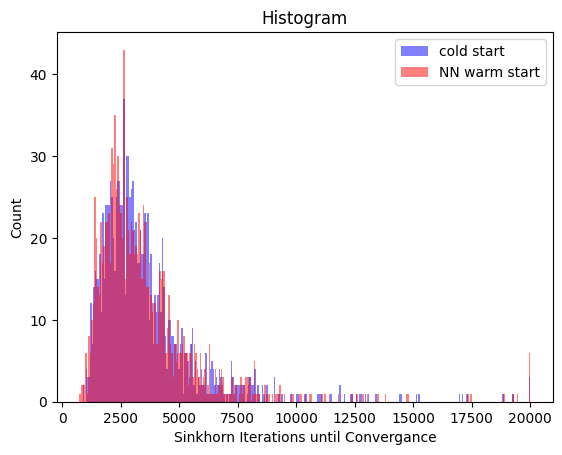

In [67]:
plt.hist(cold_iters, bins=300, alpha=.5, color='blue', label='cold start')
plt.hist(warm_iters, bins=300, alpha=.5, color='red', label='NN warm start')
plt.xlabel("Sinkhorn Iterations until Convergance")
plt.ylabel("Count")
plt.title("Histogram")
plt.legend()
plt.show()

In [51]:
# 5 num sum
cold_min = np.min(cold_iters)
cold_q1 = np.percentile(cold_iters, 25)
cold_med = np.median(cold_iters)
cold_q3 = np.percentile(cold_iters, 75)
cold_max = np.max(cold_iters)

warm_min = np.min(warm_iters)
warm_q1 = np.percentile(warm_iters, 25)
warm_med = np.median(warm_iters)
warm_q3 = np.percentile(warm_iters, 75)
warm_max = np.max(warm_iters)

print(f"Cold: {int(cold_min)}\t {int(cold_q1)}\t {int(cold_med)}\t {int(cold_q3)}\t {cold_max}")
print(f"Warm: {int(warm_min)}\t {int(warm_q1)}\t {int(warm_med)}\t {int(warm_q3)}\t {warm_max}")

# max iters was capped at 20000
# Cold: 884	 2264	 3031	 4217	 20000
# Warm: 737	 2193	 2976	 4219	 20000

Cold: 884	 2264	 3031	 4217	 20000
Warm: 737	 2193	 2976	 4219	 20000


# Functions

In [52]:
#@title fast_kmeans(x, k, max_iters=100, tol=1e-3)
def fast_kmeans(x, k, max_iters=100, tol=1e-3):
    """
    GPU kmeans implementation.
    kmeans_pytorch has an issue where if a center has no members you get 0/0 = NaN center_shift
    Consequently had to make my own kmeans

    Args:
        x (Tensor): data of shape (N, D)
        k (int): number of clusters
    Returns:
        labels (Tensor): (N,) cluster assignments
        centers (Tensor): (k, D) cluster centers
    """
    # pick k random points to start in
    N, D = x.shape
    indices = torch.randperm(N, device=x.device)[:k]
    centers = x[indices].clone()

    labels = torch.zeros(N, dtype=torch.long, device=x.device)

    for i in range(max_iters):
        centers_old = centers.clone()

        #calculate distances
        dists = torch.cdist(x, centers)
        labels = torch.argmin(dists, dim=1)

        new_centers = torch.zeros(k, D, device=x.device)
        counts = torch.zeros(k, device=x.device)

        #sum coordinates of points in each cluster
        new_centers.index_add_(0, labels, x)

        # count points in each cluster
        ones = torch.ones(N, device=x.device)
        counts.index_add_(0, labels, ones)

        # Replace 0s with 1s to avoid 0/0 division
        # empty clusters will be discarded later
        counts_safe = torch.clamp(counts, min=1).unsqueeze(1)
        candidates = new_centers / counts_safe

        # If count > 0, use candidate. If count == 0, keep centers_old.
        valid_mask = (counts > 0).unsqueeze(1)
        centers = torch.where(valid_mask, candidates, centers_old)

        shift = torch.norm(centers - centers_old)
        if shift < tol:
            break

    return labels, centers

In [53]:
#@title get_palette(image_path, k=128, testing=False)
def get_palette(image_path, k=128, testing=False):
  '''
  Runs k-means clustering on the Lab-space colors of the input picture.
  RGB distance is not useful, Delta E distance in Lab space correctly models how differenently humans view colors.

  Want everything to run on GPU so we use kornia for rgb to lab conversion. kmeans_pytorch for kmeans

  Parameters:
    image_path: string path to image in local colab env. Should be /content/sample_images/XXXXX.jpg
    k: number of clusters to make in k-means
    testing: if True, will imshow the image get_palette is called on

  Returns:
    Centroids: (k, 3) Lab coordinates of all k cluster means
    Weights: (k,) probability distribution weighing each cluster proportional to the number of elements in it
    Pixel labels: (h*w,) cluster membership per pixel
  '''
  device = 'cuda'

  image = cv2.imread(image_path) # a numpy array

  # Important note: bgr2rgb was used here rather than bgr2lab as opencv's
  #                 lab doesn't give me the right scaling that I need between
  #                 the L, a, b values. Has to do because they use 8 bit "quantization,"
  #                 but I didn't look too deep into what that meant
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_tensor = torch.from_numpy(image_rgb).permute(2, 0, 1) # get to (3, height, width)
  image_tensor = image_tensor.unsqueeze(0).to(device) # (1, 3, height, width). kornia expects (batch size, num channels, height, width)
  image_tensor = image_tensor.float() / 255.0

  lab_image_tensor = kornia.color.rgb_to_lab(image_tensor) #bgr_to_lab does not exist

  if testing:
    print(type(image_rgb))
    print(image_rgb.shape)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    print(type(lab_image_tensor))
    print(lab_image_tensor.shape)
    # plot from cpu
    lab_vis = lab_image_tensor[0].permute(1,2,0).cpu().detach().numpy()
    plt.imshow(lab_vis)
    plt.axis("off")
    plt.show()

  pixels = lab_image_tensor[0].view(3, -1).permute(1, 0).contiguous() #-1 here implicitly combines height and width

  #kmeans only cares about color distance so we view lab_image_tensor to just be ((h*w), 3)
  cluster_ids_x, cluster_centers = fast_kmeans(x=pixels, k=k)

  counts = torch.bincount(cluster_ids_x, minlength=k)
  weights = counts / counts.sum()

  return cluster_centers.cpu(), weights.cpu(), cluster_ids_x.cpu()

In [54]:
#@title sinkhorn(a, b, cost_matrix, epsilon=.1, max_iters=20000, initial_guess=None)
def sinkhorn(a, b, cost_matrix, epsilon=.1, max_iters=20000, initial_guess=None):
  '''
  My sinkhorn implementation.
  Uses log probabilities to avoid underflow.

  Parameters:
    a: (n,) left/source probability vector
    b: (m,) right/target probability vector
    cost_matrix: (n,m) cost matrix in euclidean space
    epsilon: smoothing parameter for the gibbs kernel

  Returns:
    (n,m) matrix depicting the optimal transport matrix from a to b
  '''
  M = cost_matrix # just renaming
  logK = -M/epsilon
  if initial_guess is not None:
    P0 = initial_guess.clamp_min(1e-12) # avoid log(0)
    logR = torch.log(P0) - logK # approx logu[:,None] + log_v[None,:]
    log_v = torch.zeros(logR.shape[1]).to('cuda')
    for _ in range(10):
      log_u = (logR - log_v.unsqueeze(0)).mean(dim=1)
      log_v = (logR - log_u.unsqueeze(1)).mean(dim=0)
  else:
    log_v = torch.zeros_like(b)

  past_log_v = log_v
  log_a = torch.log(a)
  log_b = torch.log(b)
  log_eps = torch.log(torch.tensor(epsilon))

  iters_done = max_iters
  for i in range(max_iters):
    log_u = log_a - torch.logsumexp(logK + log_v, 1)
    log_v = log_b - torch.logsumexp(logK.T + log_u, 1)

    if torch.allclose(log_v, past_log_v, atol=1e-4, rtol=0):
      iters_done = i
      break

    past_log_v = log_v

  return torch.exp(log_u[:, None] - M / epsilon + log_v[None, :]), iters_done

In [55]:
#@title run_sinkhorn_pipeline(source_filename, target_filename, show_before_and_after=False):
def run_sinkhorn_pipeline(source_filename, target_filename, show_before_and_after=False):
  source_img = cv2.cvtColor(cv2.imread('/content/sample_images/' + source_filename), cv2.COLOR_BGR2RGB)
  target_img = cv2.cvtColor(cv2.imread('/content/sample_images/' + target_filename), cv2.COLOR_BGR2RGB)

  source_centroids, source_weights, source_memberships = get_palette('/content/sample_images/' + source_filename)
  target_centroids, target_weights, target_memberships = get_palette('/content/sample_images/' + target_filename)

  transport_matrix, sinkhorn_iters_needed = sinkhorn(source_weights, target_weights, torch.cdist(source_centroids, target_centroids))

  new_centroids = transport_matrix @ target_centroids / source_weights.unsqueeze(1)
  membership_matrix = source_memberships.view(source_img.shape[0], source_img.shape[1])
  new_img_lab = new_centroids[membership_matrix].detach().cpu().numpy()
  new_img_rgb = cv2.cvtColor(new_img_lab, cv2.COLOR_LAB2RGB)

  if show_before_and_after:
    plt.imshow(source_img)
    plt.axis('off')
    plt.show()
    plt.imshow(target_img)
    plt.axis('off')
    plt.show()
    plt.imshow(new_img_rgb)
    plt.axis('off')
    plt.show()

  return source_img, target_img, new_img_rgb

In [56]:
#@title run_NN_pipeline(model, source_filename, target_filename, show_before_and_after=False, use_as_warm_start=False):
def run_NN_pipeline(model, source_filename, target_filename, show_before_and_after=False, use_as_warm_start=False):
  model.eval()
  source_img = cv2.cvtColor(cv2.imread('/content/sample_images/' + source_filename), cv2.COLOR_BGR2RGB)
  target_img = cv2.cvtColor(cv2.imread('/content/sample_images/' + target_filename), cv2.COLOR_BGR2RGB)

  source_centroids, source_weights, source_memberships = (x.to('cuda') for x in get_palette('/content/sample_images/' + source_filename))
  target_centroids, target_weights, target_memberships = (x.to('cuda') for x in get_palette('/content/sample_images/' + target_filename))

  source_params = torch.concat((source_centroids, source_weights.unsqueeze(1)), dim=1)
  target_params = torch.concat((target_centroids, target_weights.unsqueeze(1)), dim=1)

  P_pred = model(source_params, target_params)

  sinkhorn_iters_needed = 0
  if use_as_warm_start:
    init_guess = source_weights.unsqueeze(1) * P_pred
    P_pred, sinkhorn_iters_needed = sinkhorn(source_weights, target_weights, torch.cdist(source_centroids, target_centroids), initial_guess=init_guess)
    new_centroids = P_pred @ target_centroids / source_weights.unsqueeze(1)
  else:
    new_centroids = P_pred @ target_centroids
  membership_matrix = source_memberships.view(source_img.shape[0], source_img.shape[1])
  new_img_lab = new_centroids[membership_matrix].detach().cpu().numpy()
  new_img_rgb = cv2.cvtColor(new_img_lab, cv2.COLOR_LAB2RGB)

  if show_before_and_after:
    plt.imshow(source_img)
    plt.axis('off')
    plt.show()
    plt.imshow(target_img)
    plt.axis('off')
    plt.show()
    plt.imshow(new_img_rgb)
    plt.axis('off')
    plt.show()

  return source_img, target_img, new_img_rgb

In [57]:
#@title NN class
class AmortizerNeuralNetwork(nn.Module):
  def __init__(self, hidden_dim=256):
    super().__init__()
    # input data expected to come with [L, a, b, mass] points (centroid and weight)
    # Made encoders deeper and wider (256 dim) to better approximate transport cost
    self.source_enc = nn.Sequential(
        nn.Linear(4, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim)
    )
    self.target_enc = nn.Sequential(
        nn.Linear(4, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim)
    )
    self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

  def forward(self, src, tgt):
    queries = self.source_enc(src)
    keys = self.target_enc(tgt)

    #cross attention
    attn_output, attn_weights = self.attention(queries, keys, keys) # same as self.attention.forward(...)
    return attn_weights


In [58]:
#@title load model
def load_model():
  model = AmortizerNeuralNetwork().to('cuda')
  state = torch.load('/content/model_state.pt')
  model.load_state_dict(state)
  return model
model = load_model()

In [59]:
def full_display_images(source_filename, target_filename):
  src_img, tgt_img, new_car_sinkhorn_img = run_sinkhorn_pipeline(source_filename, target_filename, show_before_and_after=False)
  _, _, new_car_NN_cold_img = run_NN_pipeline(model, source_filename, target_filename, show_before_and_after=False, use_as_warm_start=False)
  _, _, new_car_NN_warm_img = run_NN_pipeline(model, source_filename, target_filename, show_before_and_after=False, use_as_warm_start=True)

  labels = ["source", "target", "transformed (sinkhorn)", "transformed (NN cold)", "transformed (NN warm)", ""]
  imgs = [src_img, tgt_img, new_car_sinkhorn_img, new_car_NN_cold_img, new_car_NN_warm_img, np.array([[]])]

  fig, axes = plt.subplots(2, 3, figsize=(16, 10))
  axes = axes.ravel()

  for ax, img, lab in zip(axes, imgs, labels):
      ax.imshow(img)
      ax.set_title(lab)
      ax.axis("off")

  plt.tight_layout()
  plt.show()


# Example images

/tmp/ipython-input-1309040863.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(img)


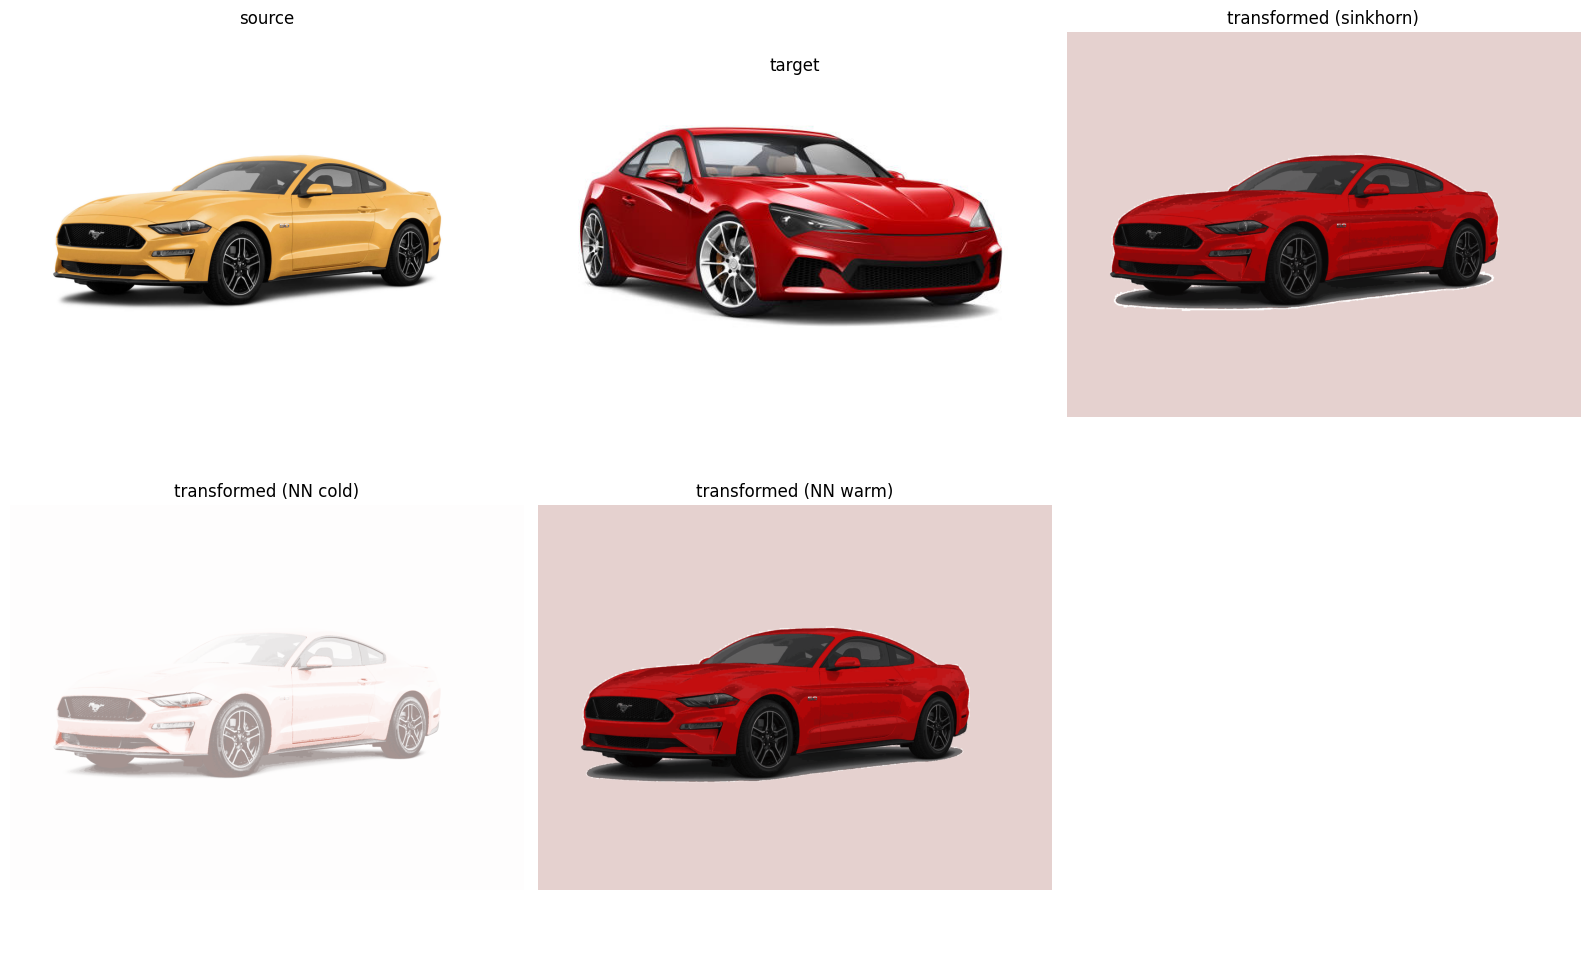

In [60]:
full_display_images('yellowCar.jpg', 'redCar.jpg')

/tmp/ipython-input-1309040863.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(img)


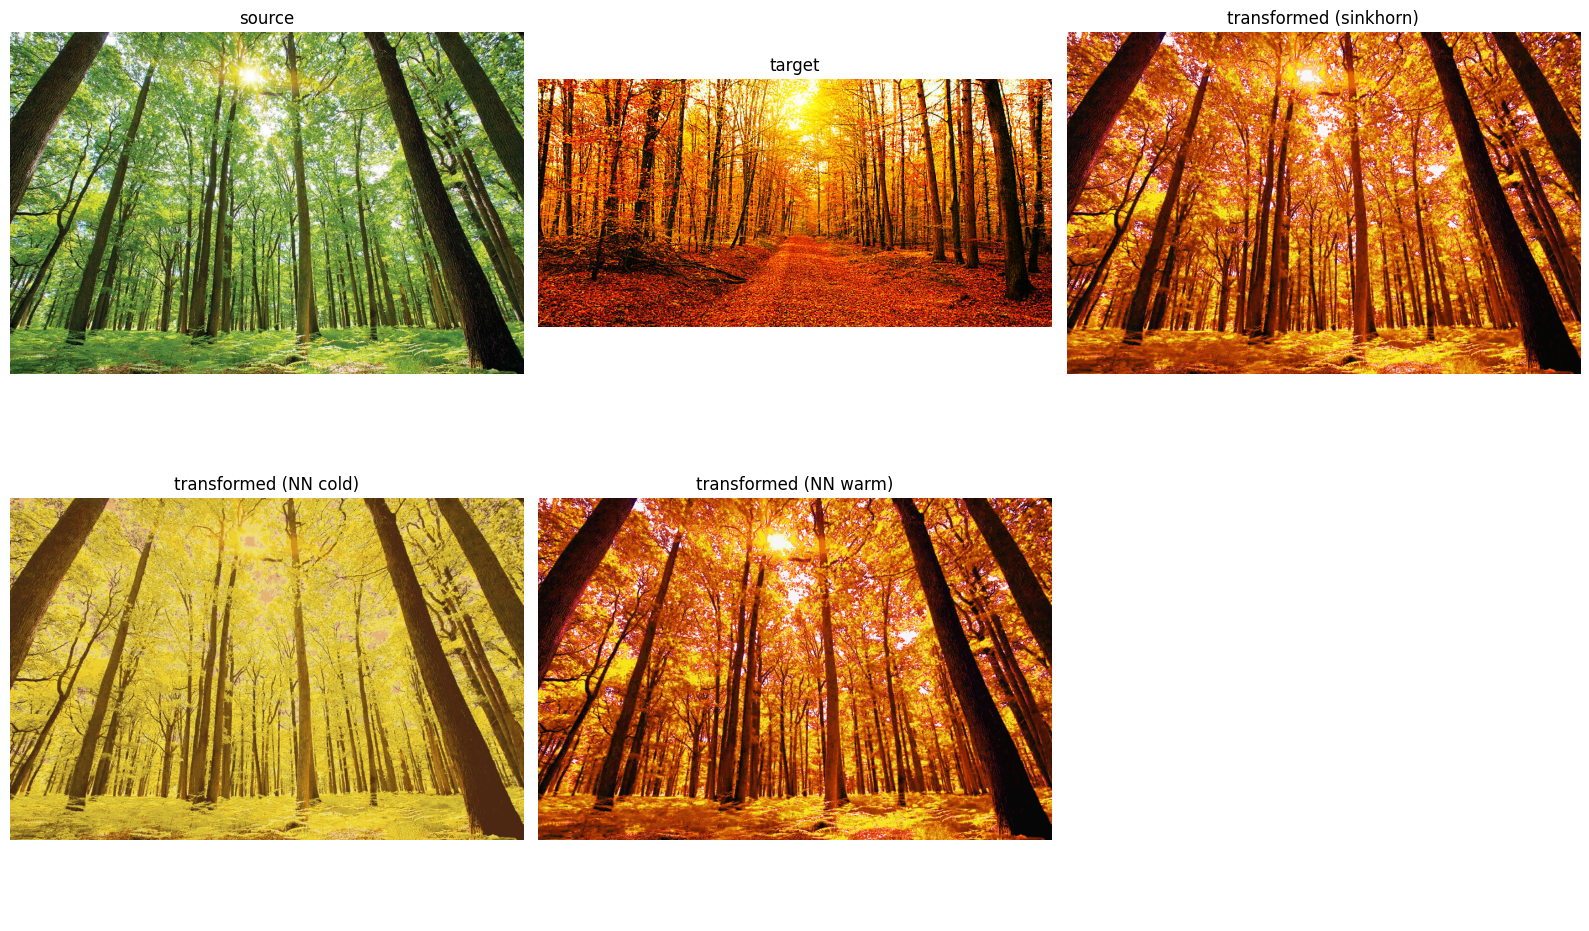

In [61]:
full_display_images('greenForest.jpg', 'orangeForest.jpg')

/tmp/ipython-input-1309040863.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(img)


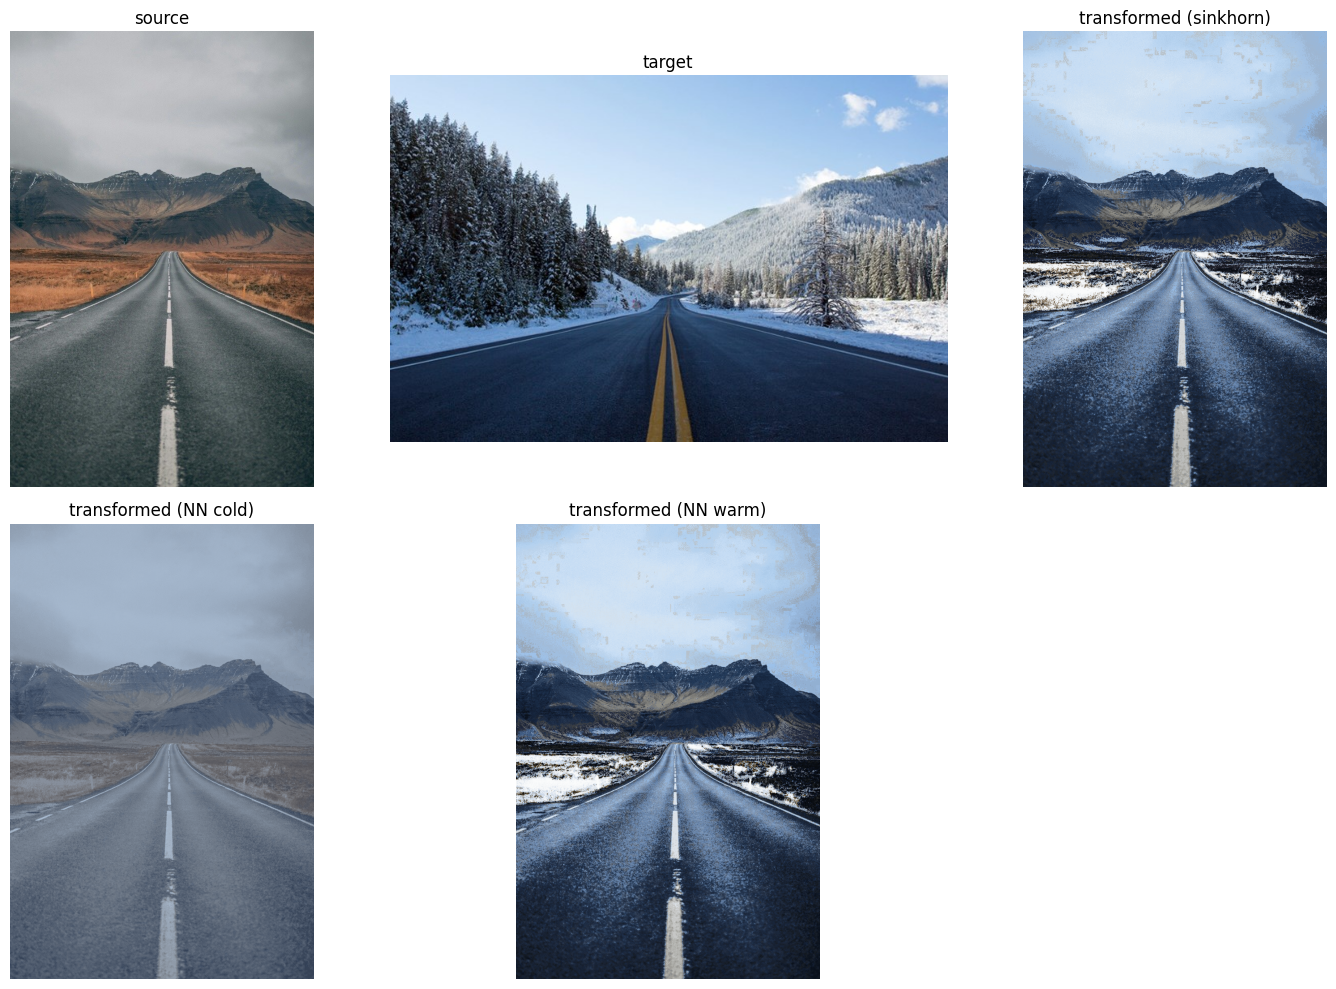

In [62]:
full_display_images('roadDesert.jpg', 'roadWinter.jpg')

/tmp/ipython-input-1309040863.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(img)


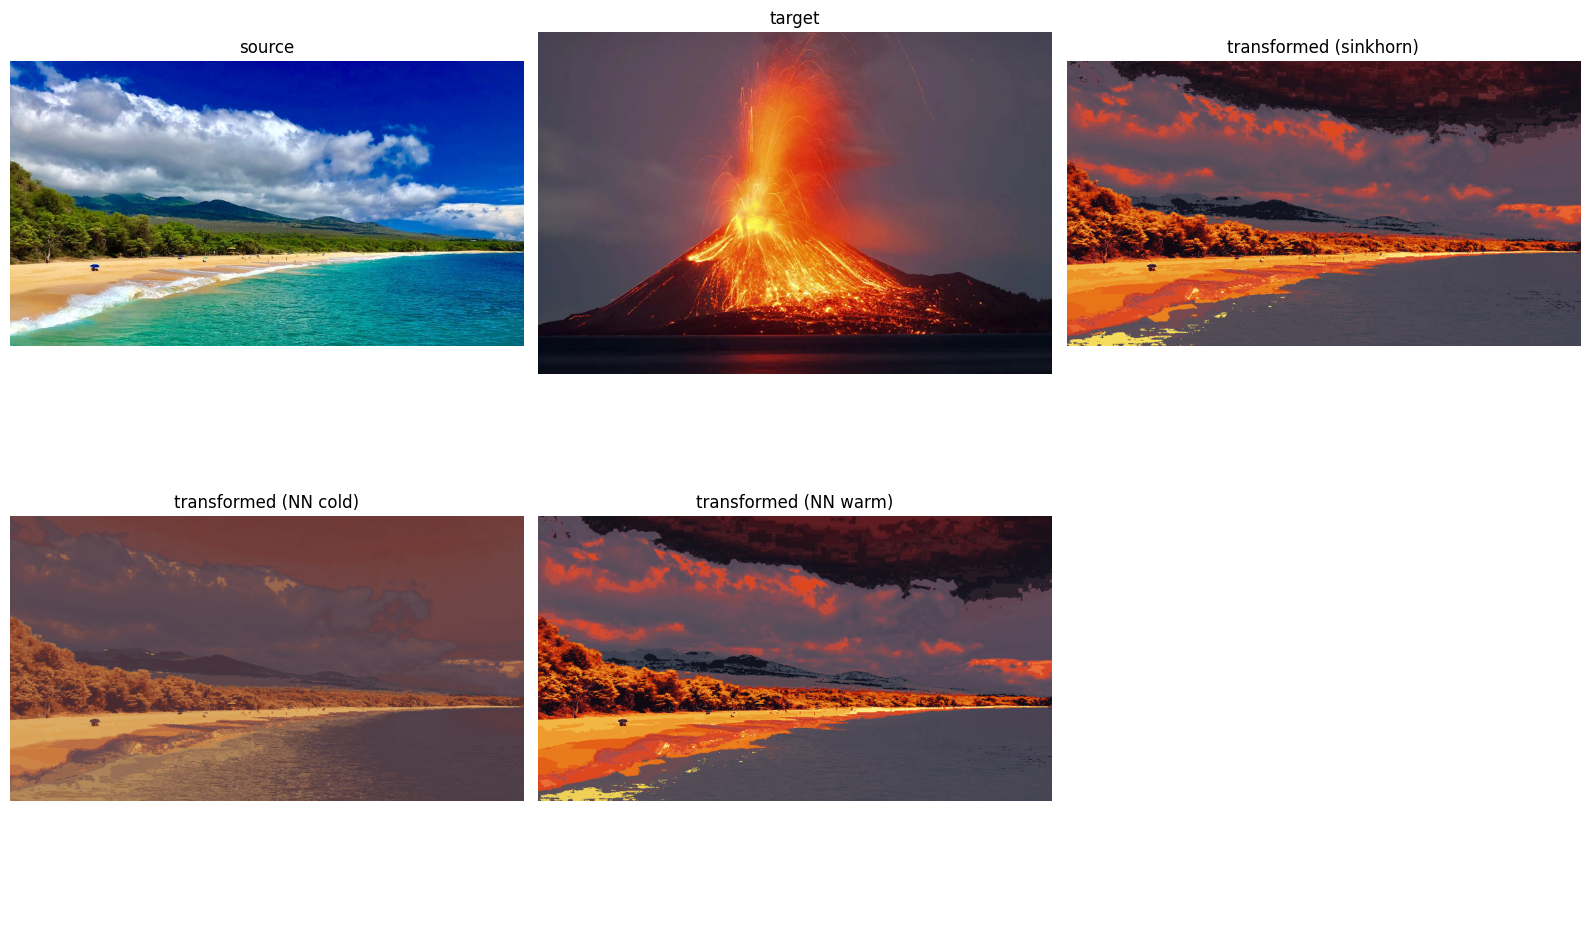

In [63]:
full_display_images('beach.jpg', 'volcano.jpg')

/tmp/ipython-input-1309040863.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(img)


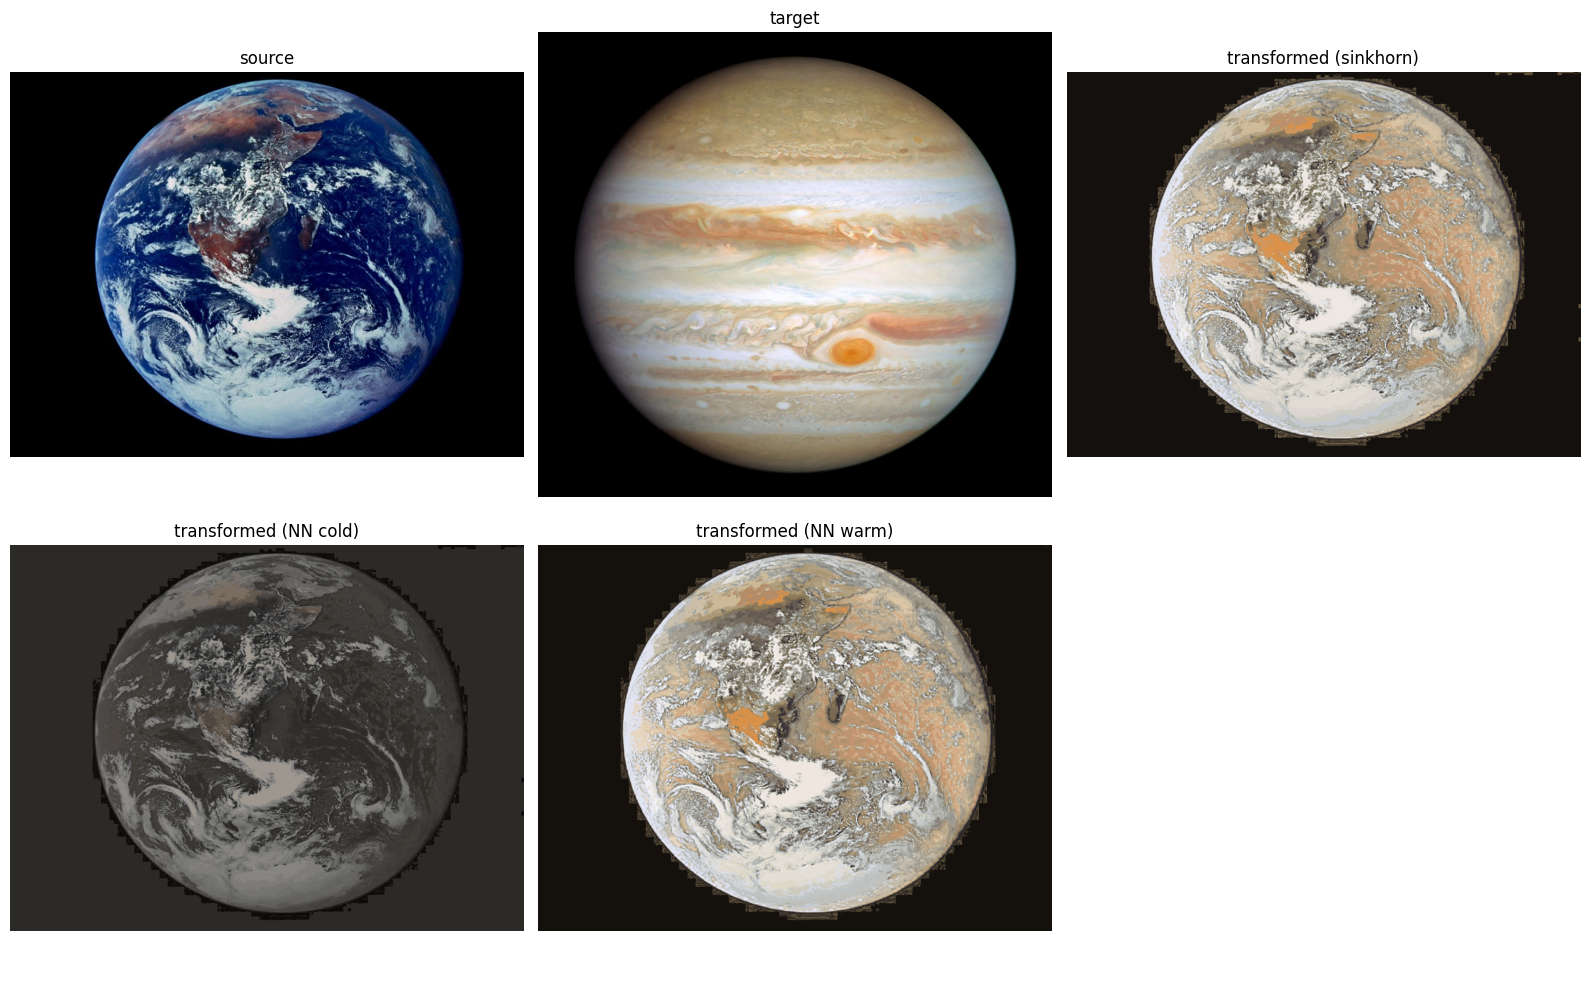

In [64]:
full_display_images('earth.jpg', 'jupiter.jpg')